# Замер производительности SomeSAT

В данной среде представлен замер производительности реализации алгоритма DPLL. 

[Репозиторий с реализацией алгоритма на языке F#](https://github.com/artem-burashnikov/SomeSAT).

Последующие разделы включают характеристики используемого оборудования и способ подготовки тестового стенда, описание набора тестовых данных, используемые метрики, исследовательские гипотезы и анализ полученных результатов.

---

## Характеристики используемого оборудования

Ниже приведены основные характеристики и команды `bash` для их вывода.

### Использованные команды

`cat /etc/os-release` &mdash; информация об операционной системе.

`lscpu` &mdash; информация об используемом процессоре.

`free -h` &mdash; информация об используемой памяти.

### Характеристики тествого стенда

1. **OS**: Ubuntu 22.04.4 LTS

2. **CPU vendor and model**: AMD Ryzen 5 4500U

3. **Architecture**: x86-64

4. **CPU frequency (MAX)**: 2.38 GHz

5. **RAM (Total)**: 7.1Gi

Измерения проводились на одном ядре на одном потоке.

---

## Подготовка тестового стенда

Часть команд выполнена с помощью утилиты `cpupower`, которая может быть установлена с помощью:

```sh
sudo apt install linux-tools-common
```

Все изменения временные и вернутся в состояние по умолчанию при перезагрузке системы:

1. Отключение `swap`:

```sh
sudo swapoff -a
```

2. Установка подсистемы `CPUFreq governor` в состояние `performance`:

```sh
sudo cpupower frequency-set -g performance
```

3. Установка максимального значения для минимальной и максимальной частоты процессора для всех ядер:

```sh
sudo cpupower frequency-set -d 2.38GHz -u 2.38GHz
```

3. Сборка программы в Release (запустить в корне проекта):

```sh
dotnet build -c Release
```

3. Запуск исполняемой программы на одном ядре (в данном случае с порядковым номером 0, запустить в корне собранного проекта):

```sh
taskset -c 0 ./SomeSAT/bin/Release/net8.0/SomeSAT test_data/jnh301.cnf
```

---

## Использованная метрика

Измерено чистое время работы алгоритма в миллисекундах (то есть время работы программы за исключением времени, затраченного на операцию чтения данных из файла и операцию перевода прочитанных данных во внутреннее представление и обратно).

---

## Тестовые данные

Для измерения времени выполенения выбраны данные, время работы алгоритма на которых составляет порядка 4-5 секунд.

Тестовые данные `jnh301.cnf` размещены в директории `test_data/`, расположенной в корне текущего репозитория.

CNF содержит 100 переменных и 900 дизъюнктов. Булева формула, представленная в файле, является разрешимой.

---

## Инструмент для измерения

Для измерения времени использованы методы класса `Stopwatch`, предоставляемого `.NET`.

---

## Исследовательская гипотеза

Ожидается, что полученный набор измерений соответствует нормальному распределению.

---

## Проведение измерений

Измерений выполнены дважды, затем полученные данные проанилизированы на нормальность, проведены расчеты основных статистических величин.

При проведения замеров производительности соблюдены следующие условия:

1. Перед исполнением алгоритма вызывается `Thread.Sleep(60000)` для искусственного простоя программы в режиме ожидания.

2. Выполняется предварительный прогрев `.NET` путем неизмеряемого исполнения программы на `warmup_data.cnf` в количестве 10 итераций, после чего алгоритм выполняется на тестовых данных с замером времени исполнения без учета времени на чтение данных из файла и перевод во внутреннее представление.

In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

(array([3., 1., 5., 8., 5., 4., 6., 3., 2., 3.]),
 array([5.5997072 , 5.63072022, 5.66173324, 5.69274626, 5.72375928,
        5.7547723 , 5.78578532, 5.81679834, 5.84781136, 5.87882438,
        5.9098374 ]),
 <BarContainer object of 10 artists>)

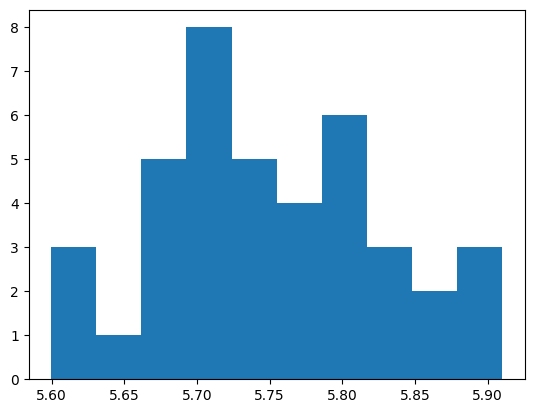

In [2]:
m = open("measurements2.txt", "r")
t = [float(x.strip())/1000.0 for x in m.readlines()]
plt.hist(t)

In [3]:
stats.normaltest(t)

NormaltestResult(statistic=0.4762989217200999, pvalue=0.7880848944448795)

In [4]:
stats.shapiro(t)

ShapiroResult(statistic=0.9758090516870385, pvalue=0.5375342998807435)

In [5]:
m.close()

---

## Анализ полученных результатов

Полученная гистограмма и p-values соответствуют нормальному распределению, что согласуется с выдвинутой гипотезой.

### Вычисление основных статистических величин

**Среднее**:

In [6]:
np.mean(t)

5.7485281950000005

**Стандартное отклонение**:

In [7]:
np.std(t, ddof=1)

0.07951631582299018

**Стандартное отклонение среднего**:

In [8]:
np.std(t, ddof=1)/sqrt(len(t))

0.012572633457296763

**Доверительный интервал**:

In [9]:
stats.t.ppf(0.975, df=len(t)-1)*stats.sem(t)

0.025430551535024545

Таким образом, итоговый интервал:

$5.75 \pm 0.03$

## Использованные ресурсы

1: https://temci.readthedocs.io/en/latest/temci_exec.html

2: https://gernot-heiser.org/benchmarking-crimes.html

3: https://ib.komisc.ru/rus/seminary/doklady-na-seminarakh?download=48:kostrova-s-n-ratsionalnoe-vypolnenie-vychislenij